# Torsion elastique

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sc
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [3]:
def load(filename: str):
    return pd.read_csv(filename)

In [4]:
laiton_raw1 = load('../data/laiton1.csv')
laiton_raw2 = load('../data/laiton2.csv')
laiton_raw3 = load('../data/laiton3.csv')
laiton_raw = [laiton_raw1, laiton_raw2, laiton_raw3]


acier_raw1 = load('../data/acier1.csv')
acier_raw2 = load('../data/acier2.csv')
acier_raw3 = load('../data/acier3.csv')
acier_raw = [acier_raw1, acier_raw2, acier_raw3]


magnesium_raw1 = load('../data/magnesium1.csv')
magnesium_raw2 = load('../data/magnesium2.csv')
magnesium_raw3 = load('../data/magnesium3.csv')
magnesium_raw = [magnesium_raw1, magnesium_raw2, magnesium_raw3]

In [5]:
# Moment d'inertie pendule
I = (masse_disque * (diametre_disque/2)**2)/2

In [6]:
def plot_datas_pd(datas, **kwargs):
    temps = unp.uarray(datas["Temps [s]"], delta_temps)
    tension = unp.uarray(datas["Tension [V]"], delta_tension)
    plt.plot(nom_vals(temps), nom_vals(tension), **kwargs)

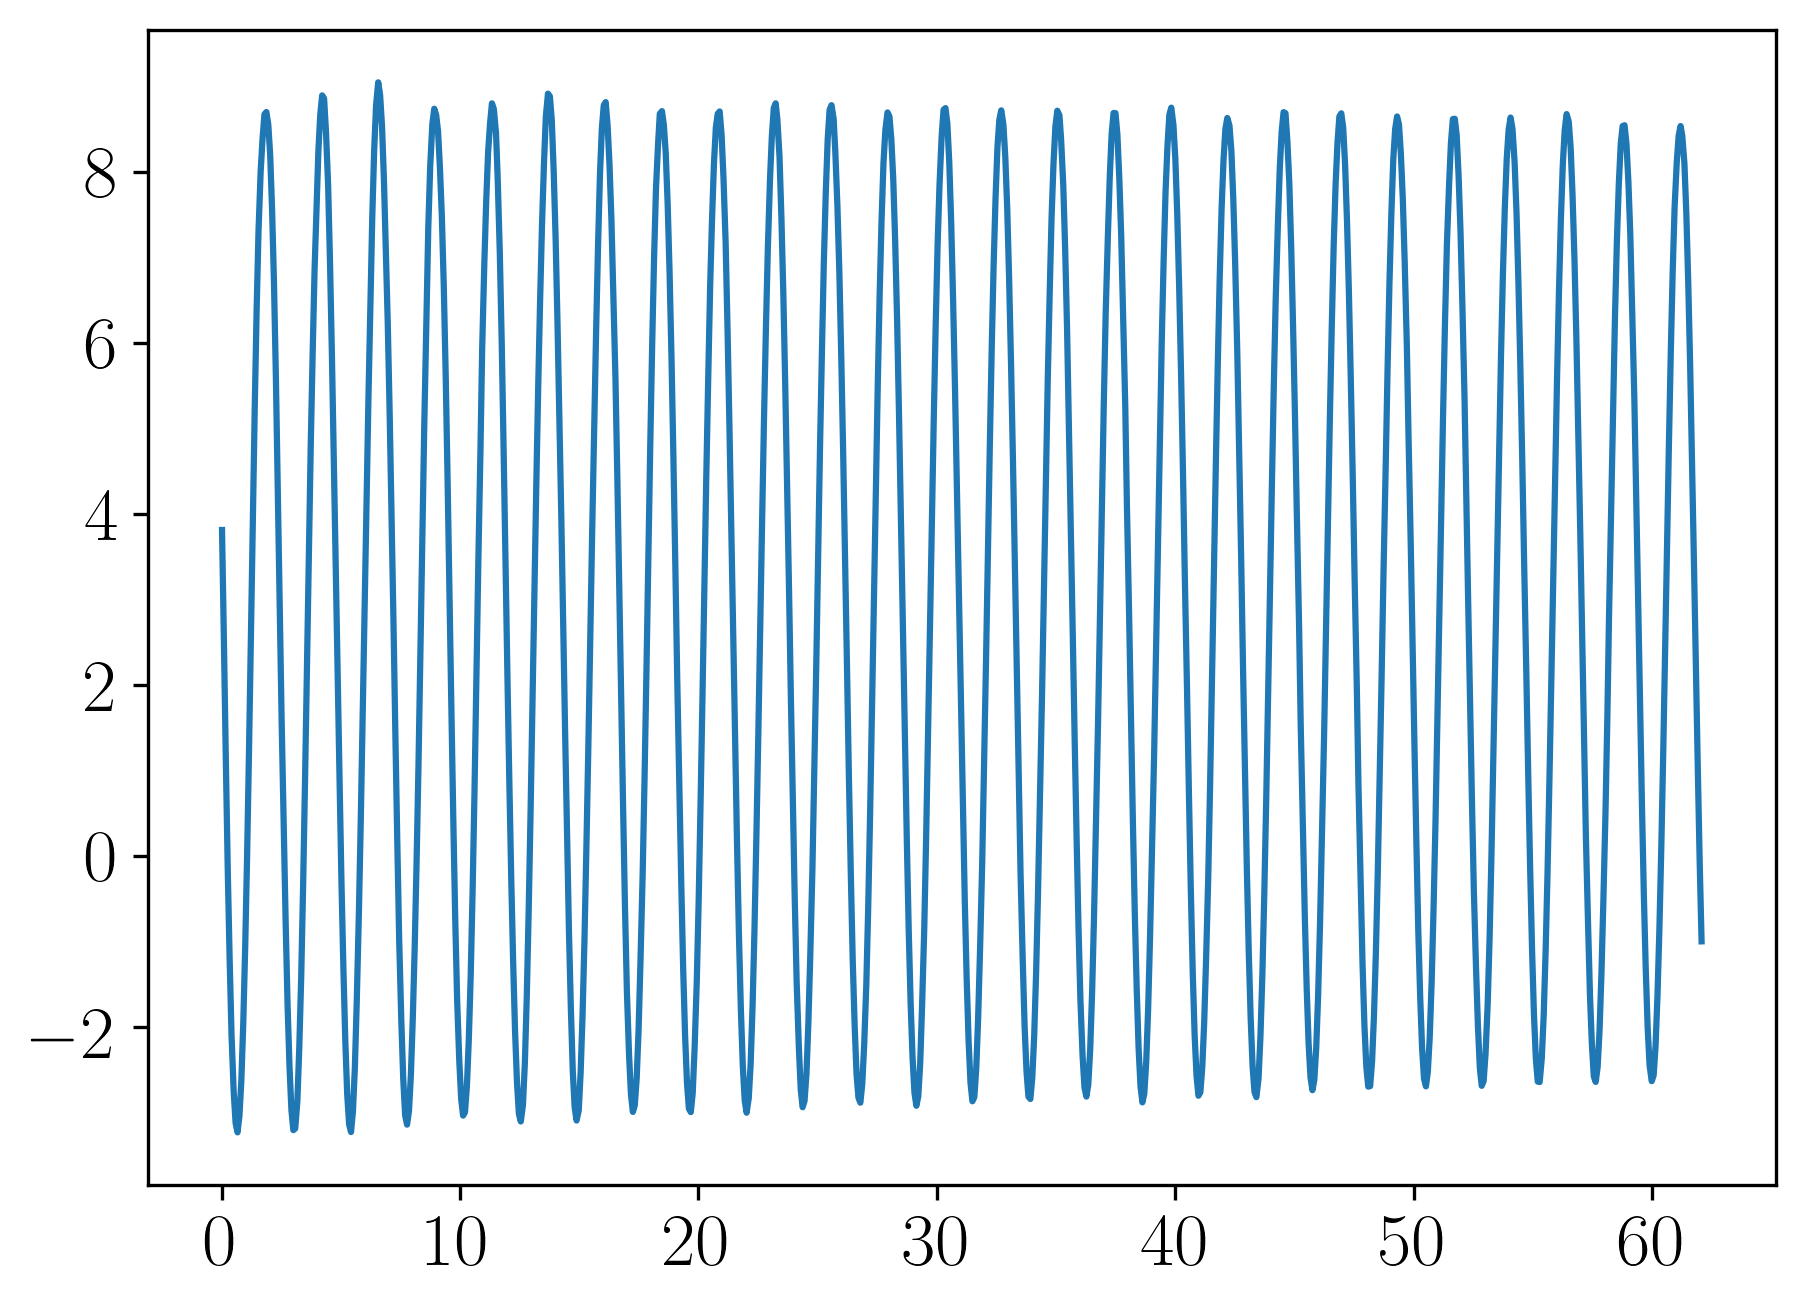

In [7]:
plot_datas_pd(laiton_raw1)

## Centrer données

In [8]:
laiton = []
acier = []
magnesium = []

for el in (laiton_raw):
    temps = unp.uarray(el["Temps [s]"], delta_temps)
    tension = unp.uarray(el["Tension [V]"], delta_tension)
    average = np.mean(tension)
    laiton.append((temps, tension-average))

for el in (acier_raw):
    temps = unp.uarray(el["Temps [s]"], delta_temps)
    tension = unp.uarray(el["Tension [V]"], delta_tension)
    average = np.mean(tension)
    acier.append((temps, tension-average))

for el in (magnesium_raw):
    temps = unp.uarray(el["Temps [s]"], delta_temps)
    tension = unp.uarray(el["Tension [V]"], delta_tension)
    average = np.mean(tension)
    magnesium.append((temps, tension-average))


In [9]:
def plot_datas(datas, **kwargs):
    plt.plot(nom_vals(datas[0]), nom_vals(datas[1]), **kwargs)

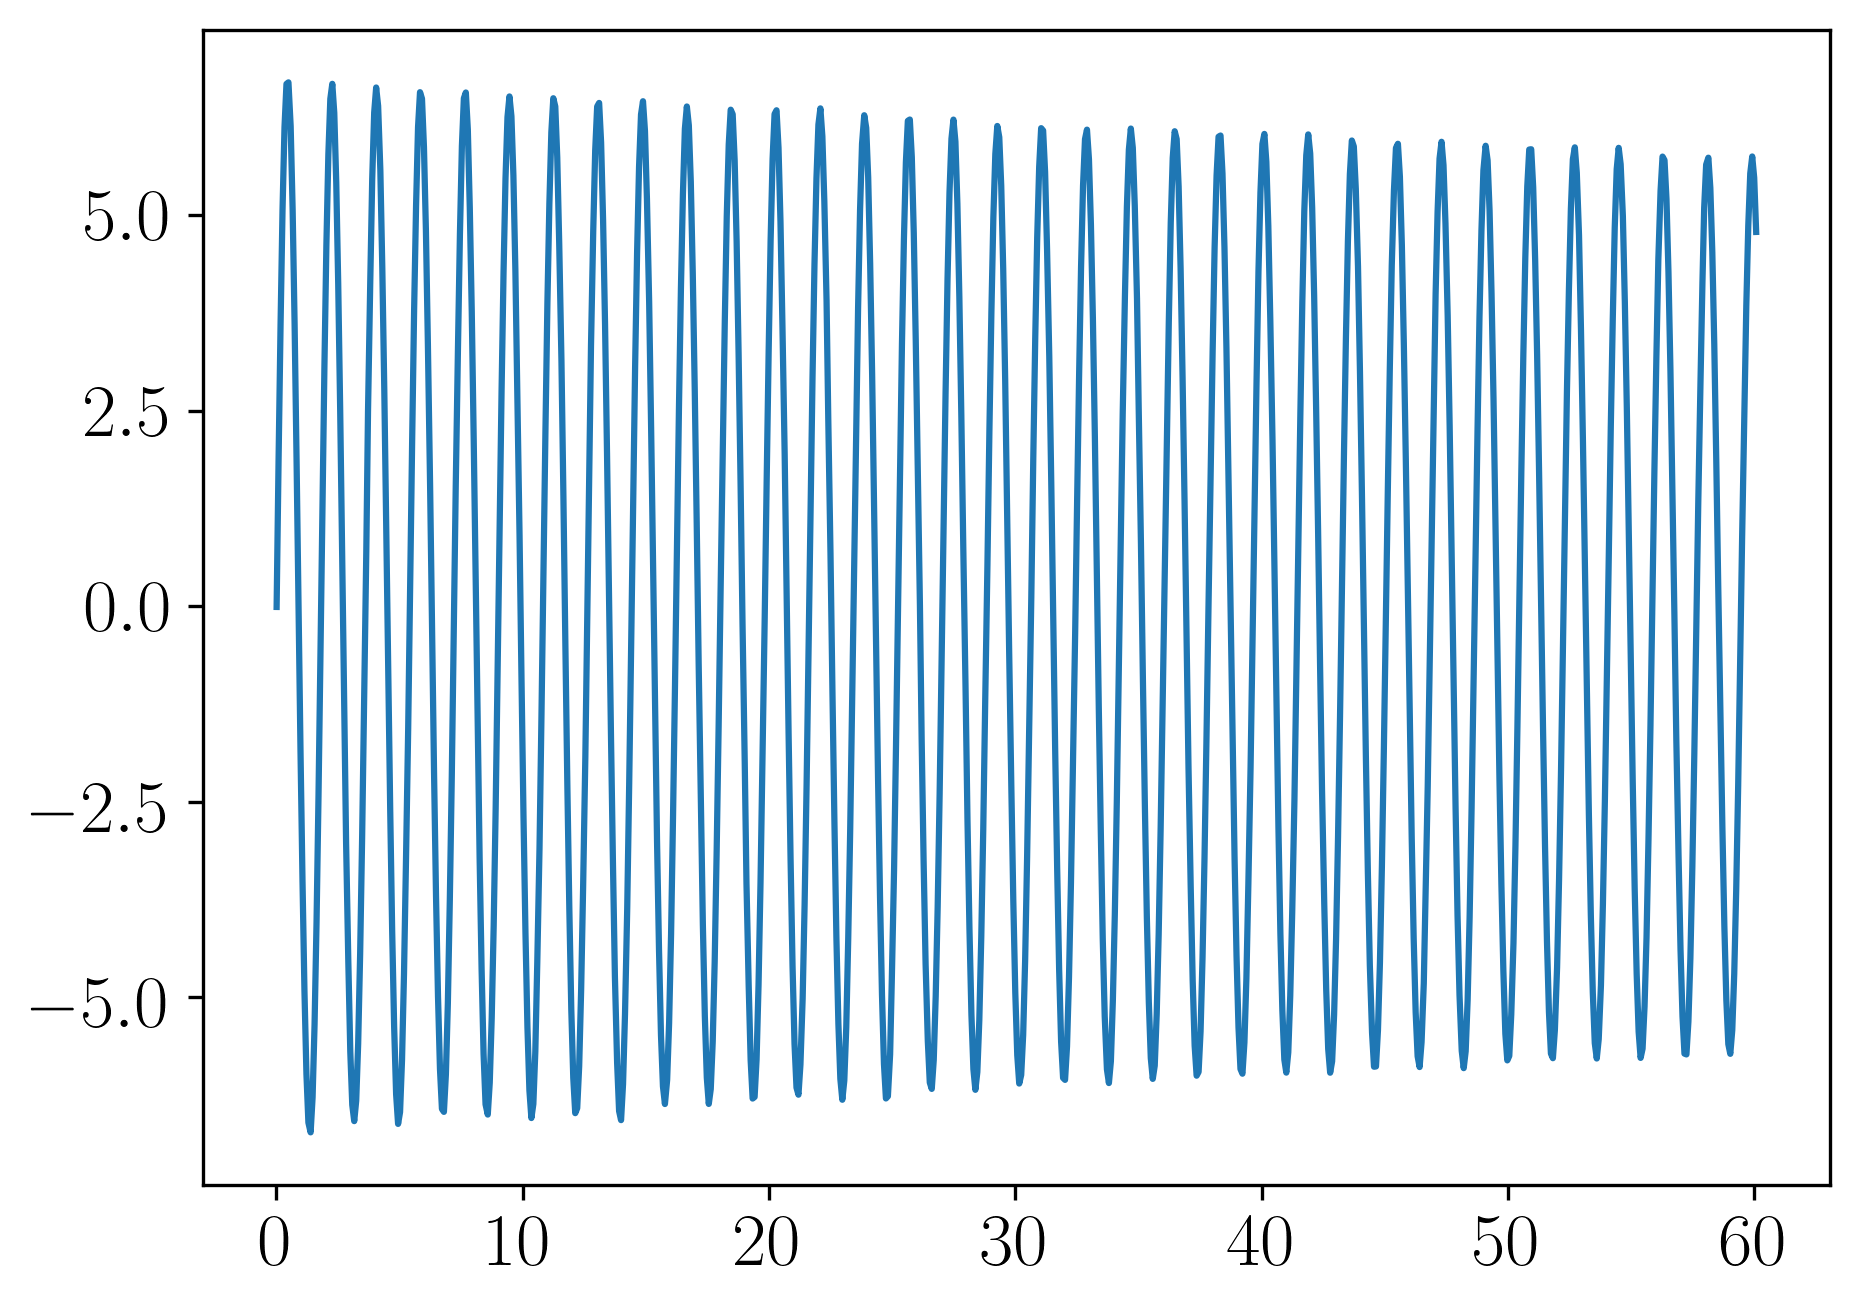

In [10]:
plot_datas(acier[1])


## Analyse classique oscillations

In [11]:
def local_max(datas):
    max_ind = sc.signal.argrelextrema(datas[1], np.greater)
    return max_ind

In [12]:
def fit_func(t, A, lmbd):
    return A * np.exp(-lmbd * t)

In [13]:
def fit_datas(datas):
    max_idx = local_max(datas)
    max_ts = datas[0][max_idx]
    maxes = datas[1][max_idx]
    coefs, pcov = sc.optimize.curve_fit(fit_func, nom_vals(max_ts), nom_vals(maxes))
    coefs_err = unp.uarray(coefs, np.sqrt(np.diag(pcov)))
    return coefs_err

In [14]:
def avg_fit(dataset):
    tot = unp.uarray((0, 0), (0, 0))
    for datas in dataset:
        coefs_err = fit_datas(datas)
        print(f"{coefs_err[1]:.1uL}")
        tot += coefs_err
    return tot / len(dataset)

In [15]:
laiton_coefs = avg_fit(laiton)
print(f"Laiton: {laiton_coefs[1]:.1ueP} ({laiton_coefs[1]:.1ueL})")

acier_coefs = avg_fit(acier)
print(f"Acier: {acier_coefs[1]:.1ueP} ({acier_coefs[1]:.1ueL})")

magnesium_coefs = avg_fit(magnesium)
print(f"Magnesium: {magnesium_coefs[1]:.1ueP} ({magnesium_coefs[1]:.1ueL})")


0.0008 \pm 0.0001
0.0009 \pm 0.0004
0.0009 \pm 0.0002
Laiton: (9±2)×10⁻⁴ (\left(9 \pm 2\right) \times 10^{-4})
0.00221 \pm 0.00009
0.00260 \pm 0.00005
0.00273 \pm 0.00006
Acier: (2.51±0.04)×10⁻³ (\left(2.51 \pm 0.04\right) \times 10^{-3})
0.0132 \pm 0.0007
0.0137 \pm 0.0003
0.0124 \pm 0.0003
Magnesium: (1.31±0.03)×10⁻² (\left(1.31 \pm 0.03\right) \times 10^{-2})


/tmp/ipykernel_41046/1386444422.py:2: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-lmbd * t)


In [16]:
def plot_with_fit(datas, **kwargs):
    coefs = fit_datas(datas)
    plt.plot(nom_vals(datas[0]), nom_vals(datas[1]), '.-', markersize=4, **kwargs)
    plt.plot(
        nom_vals(datas[0]),
        nom_vals(fit_func(nom_vals(datas[0]), coefs[0], nom_vals(coefs[1]))),
        'k--',
        label=r'$y = ({1:.1uL}) e^{{-({0:.1ueL})x}}$'.format(*reversed(coefs))
    )
    plt.xlabel(r"$t$ [\si{\second}]")
    plt.ylabel(r"$U$ [\si{\volt}]")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.97))
    # plt.grid()


/tmp/ipykernel_41046/1386444422.py:2: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-lmbd * t)


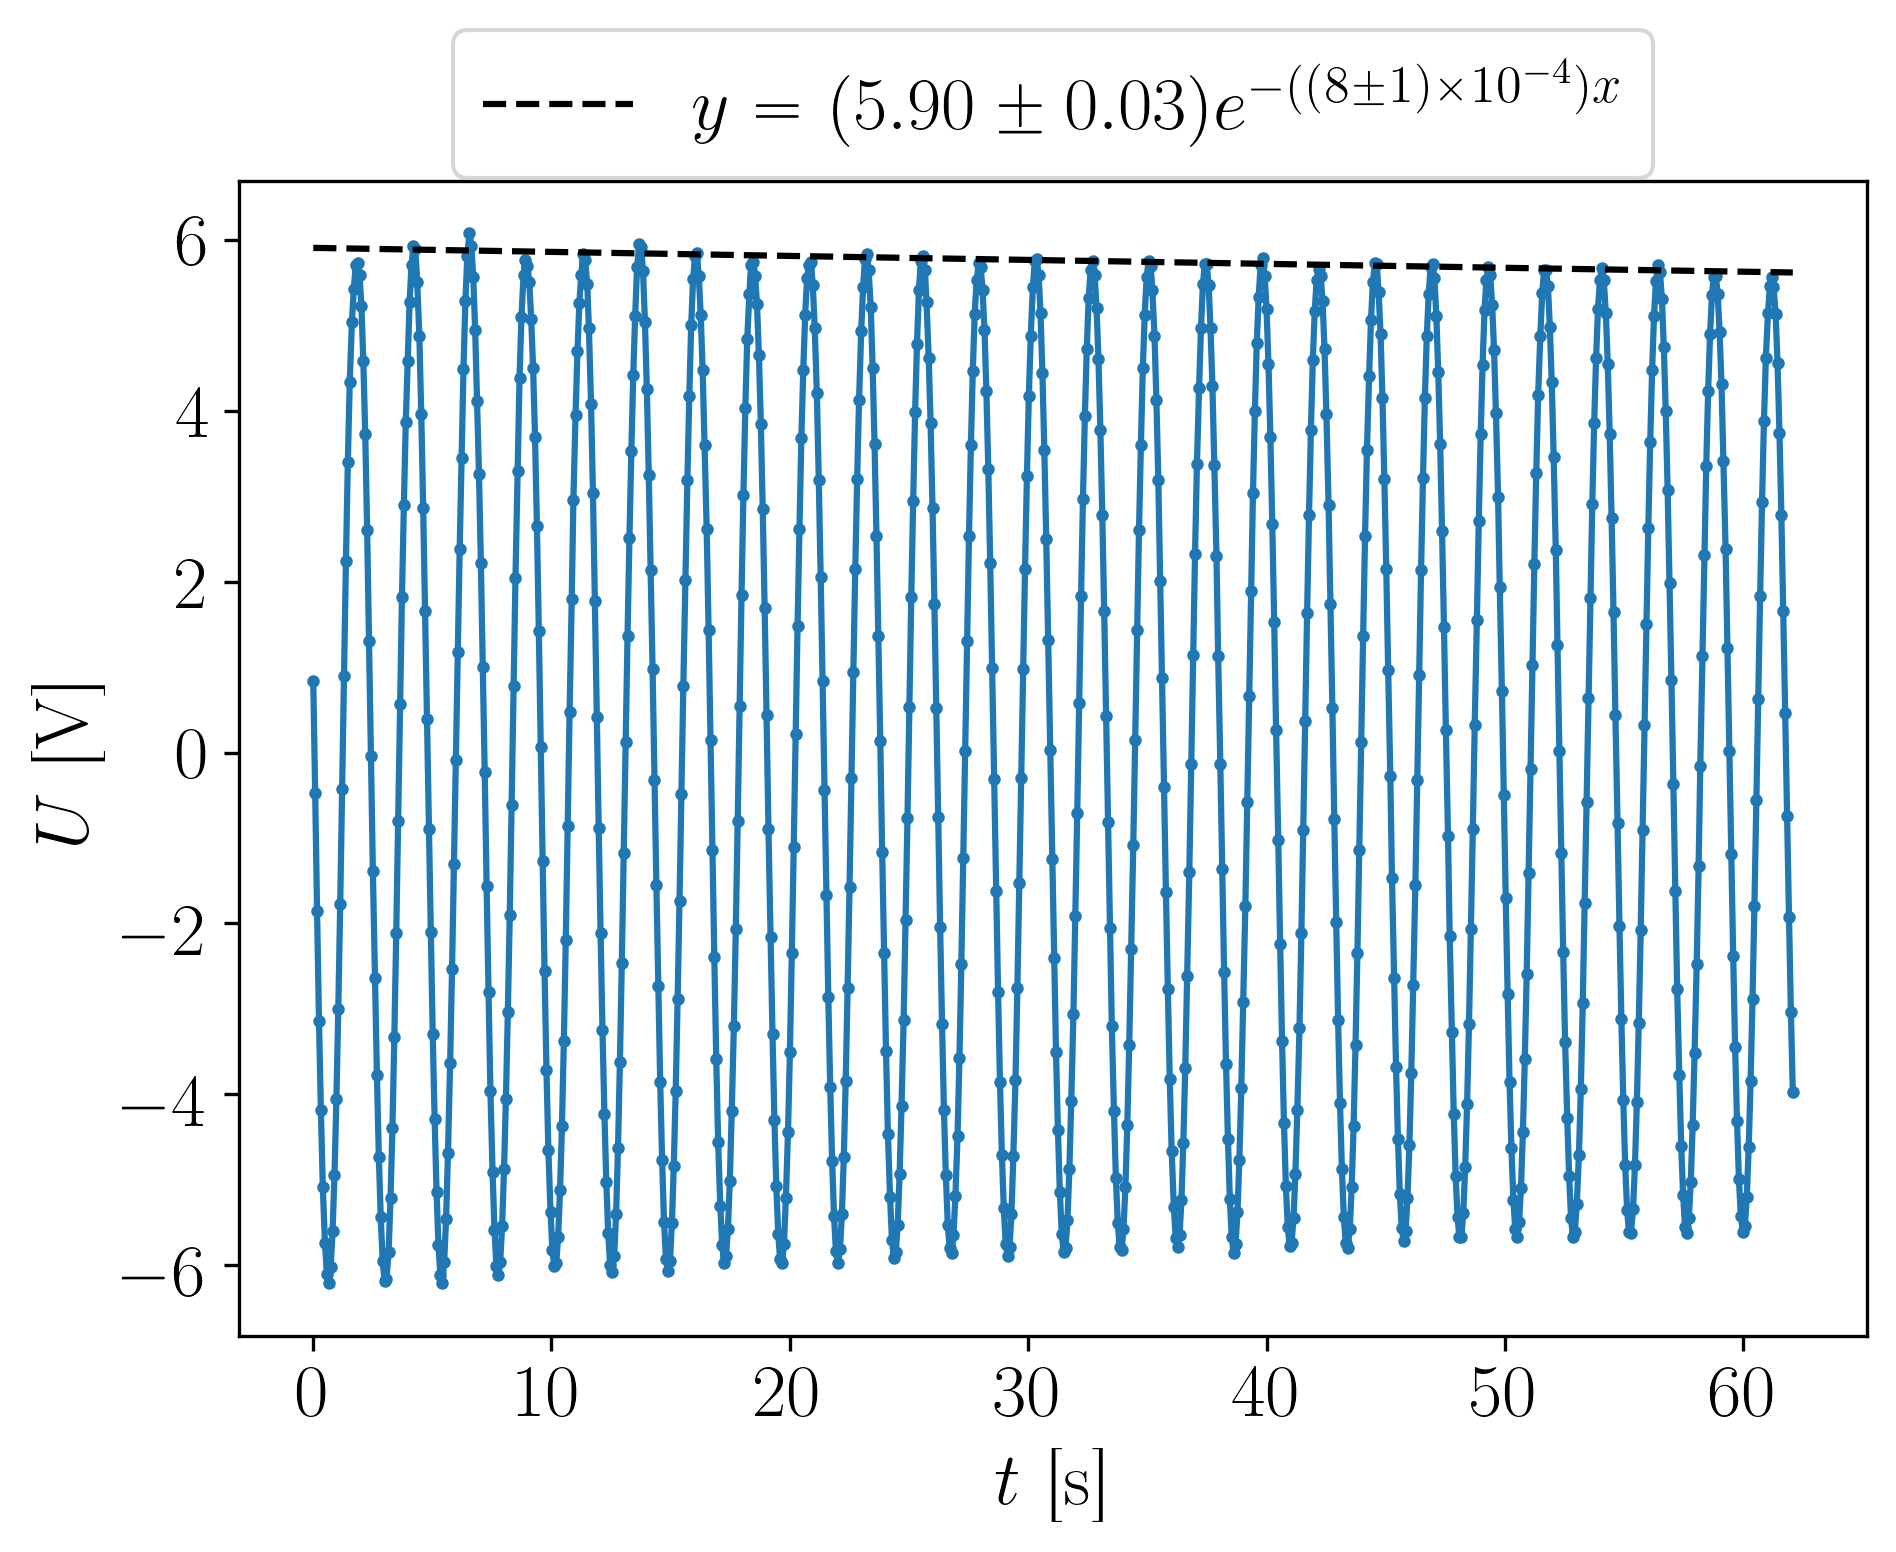

In [17]:
plot_with_fit(laiton[0], c='tab:blue')
plt.savefig('../figures/laiton1.pdf')
plt.show()

/tmp/ipykernel_41046/1386444422.py:2: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-lmbd * t)


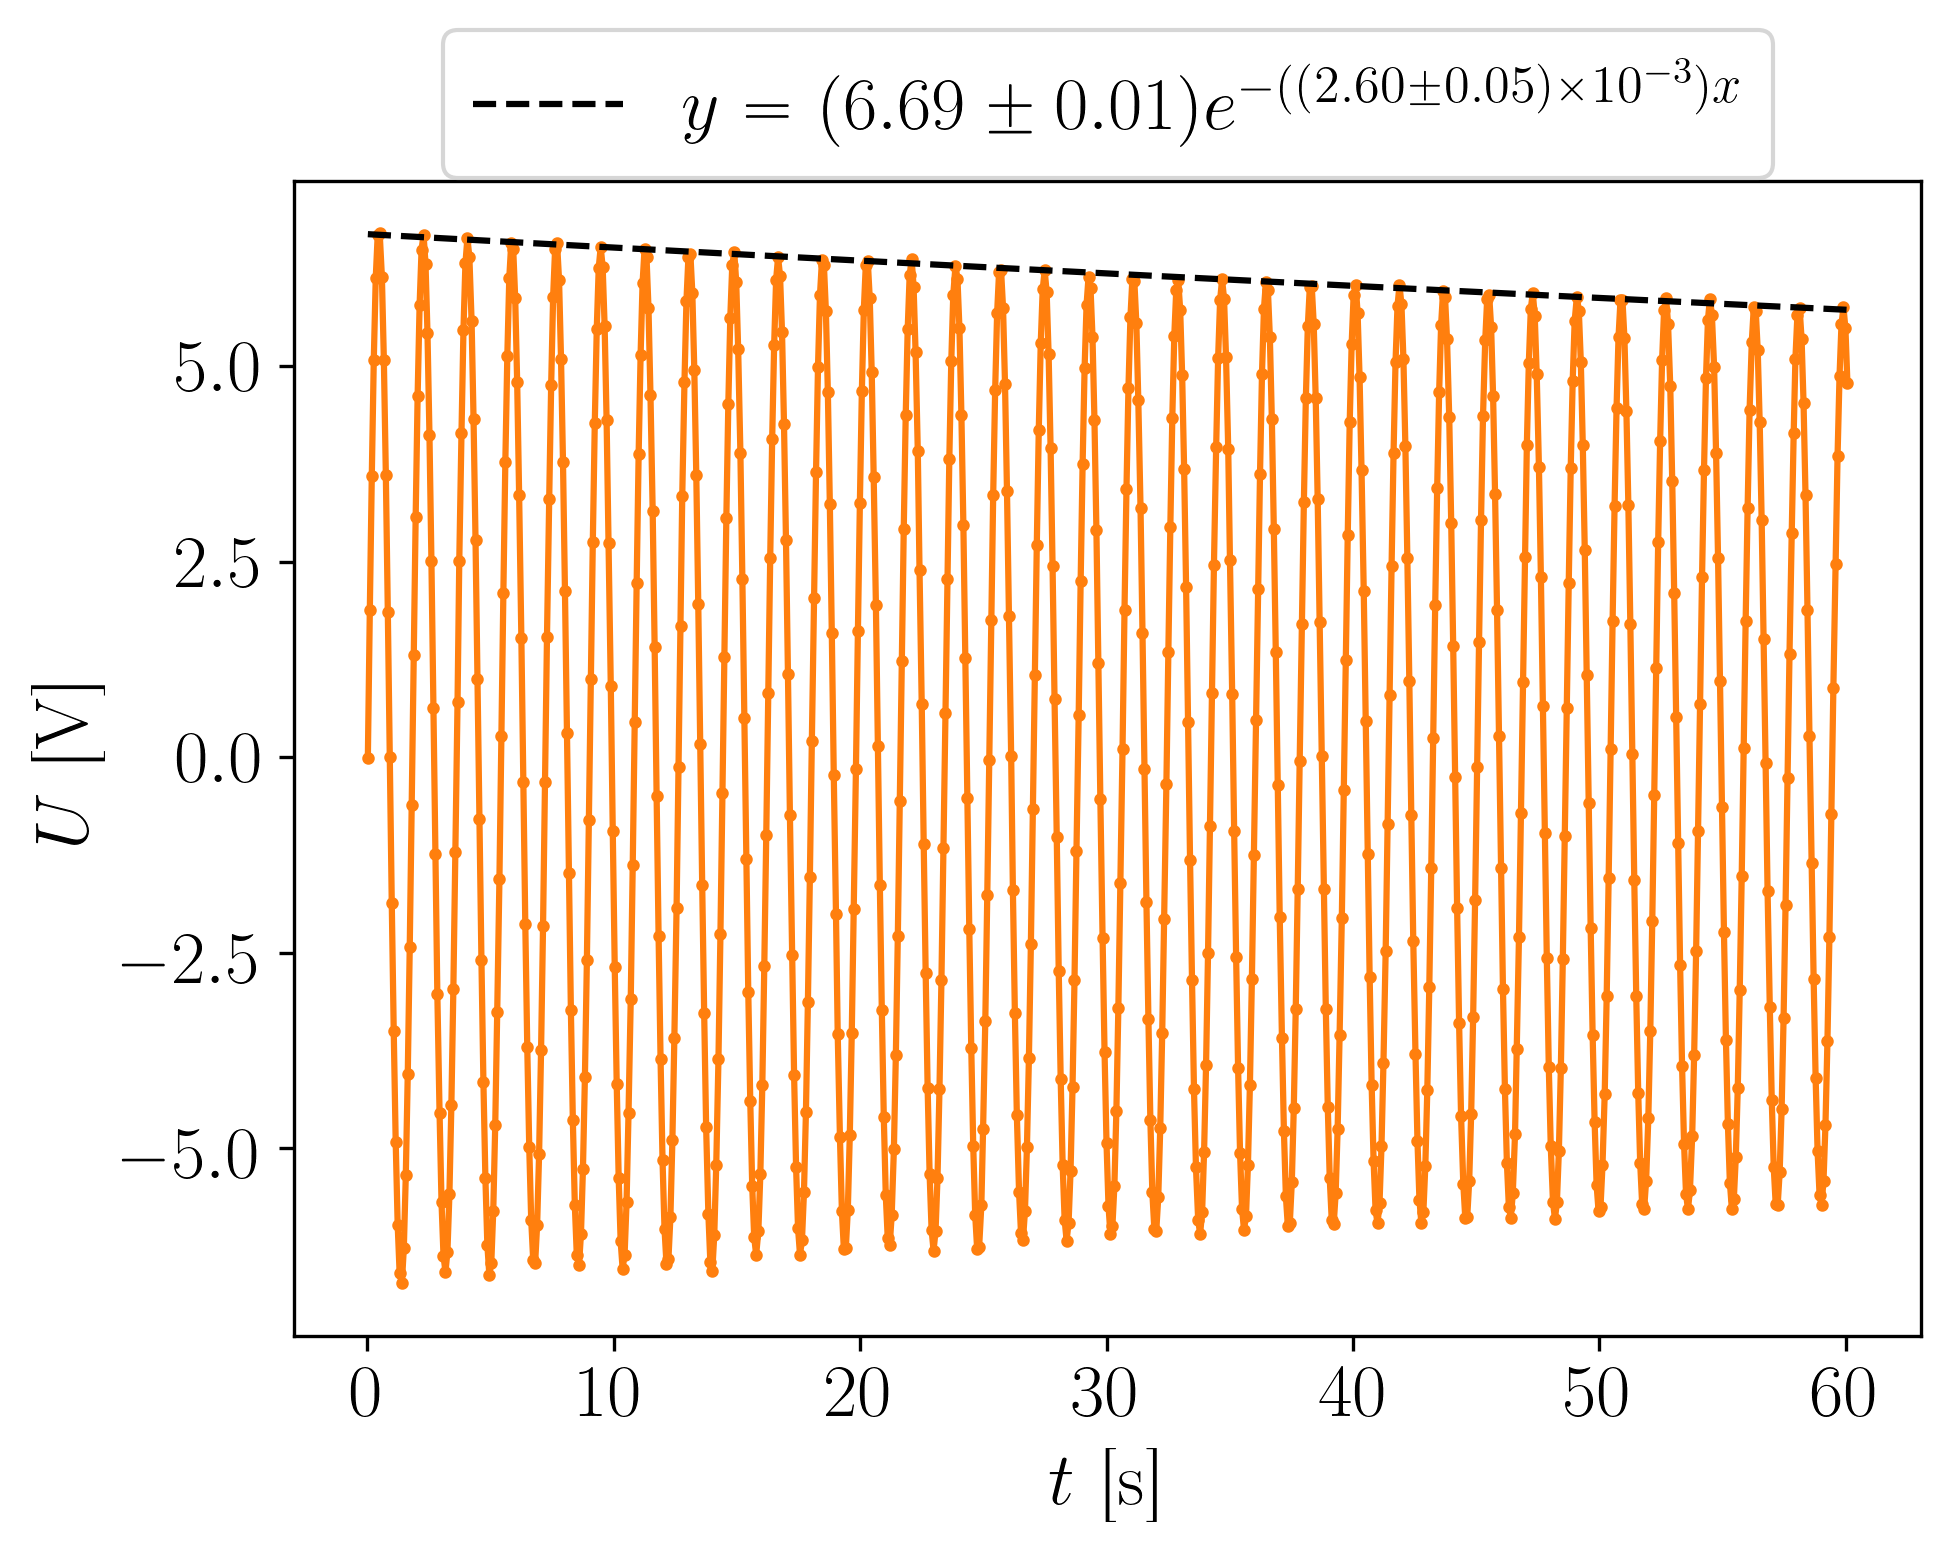

In [18]:

plot_with_fit(acier[1], c='tab:orange')
plt.savefig('../figures/acier1.pdf')
plt.show()

/tmp/ipykernel_41046/1386444422.py:2: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-lmbd * t)


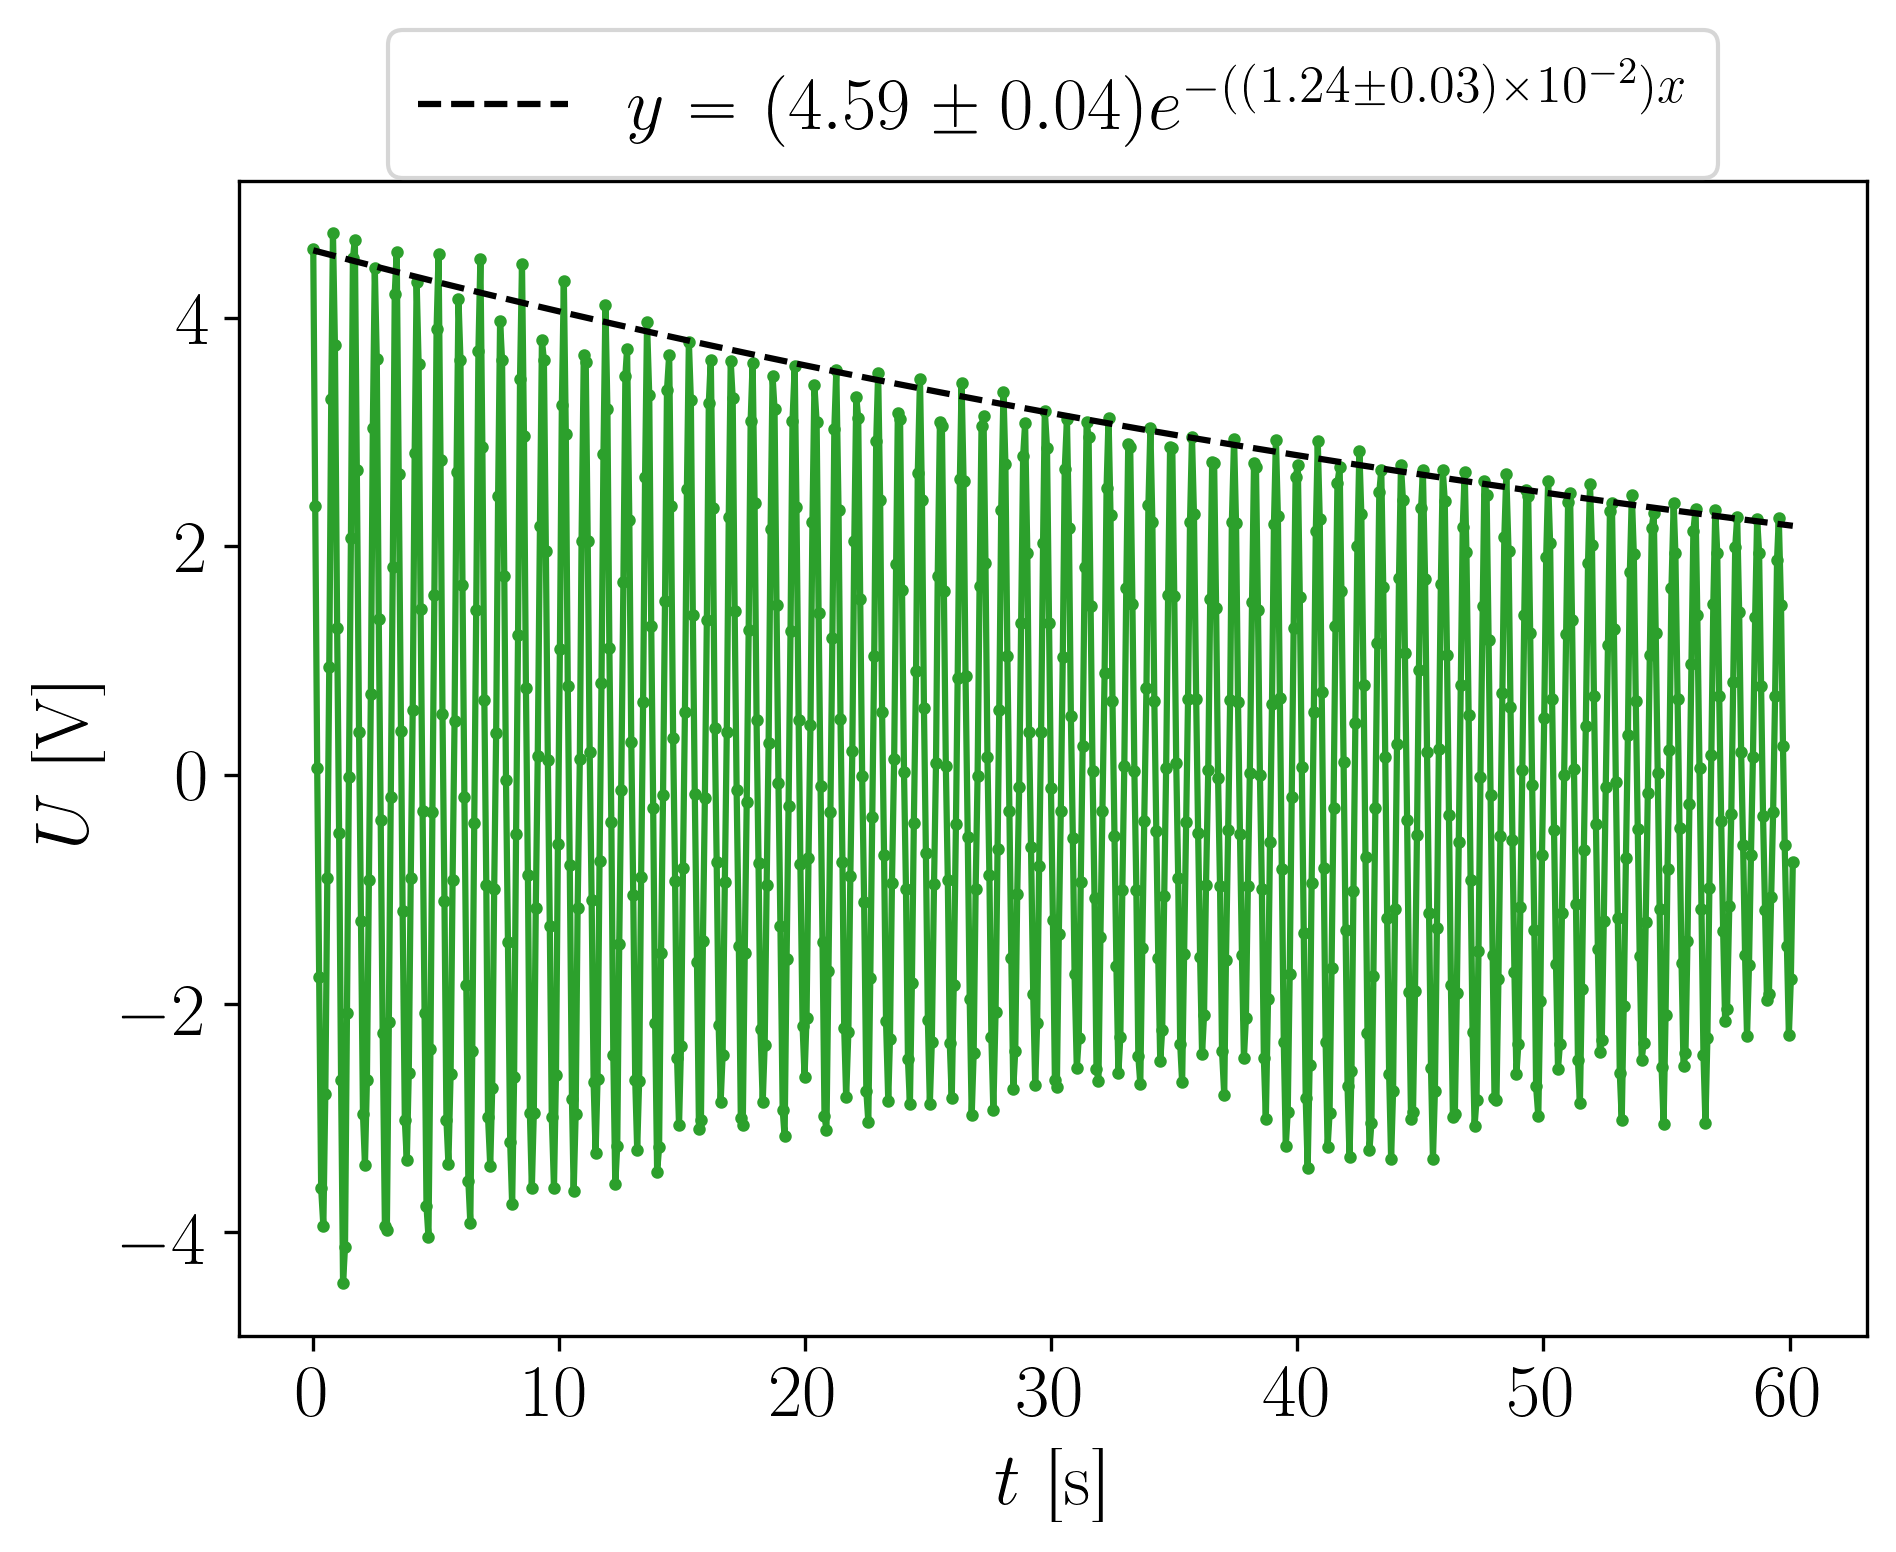

In [19]:
plot_with_fit(magnesium[2], c='tab:green')
plt.savefig('../figures/magnesium3.pdf')
plt.show()

/tmp/ipykernel_41046/1386444422.py:2: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-lmbd * t)


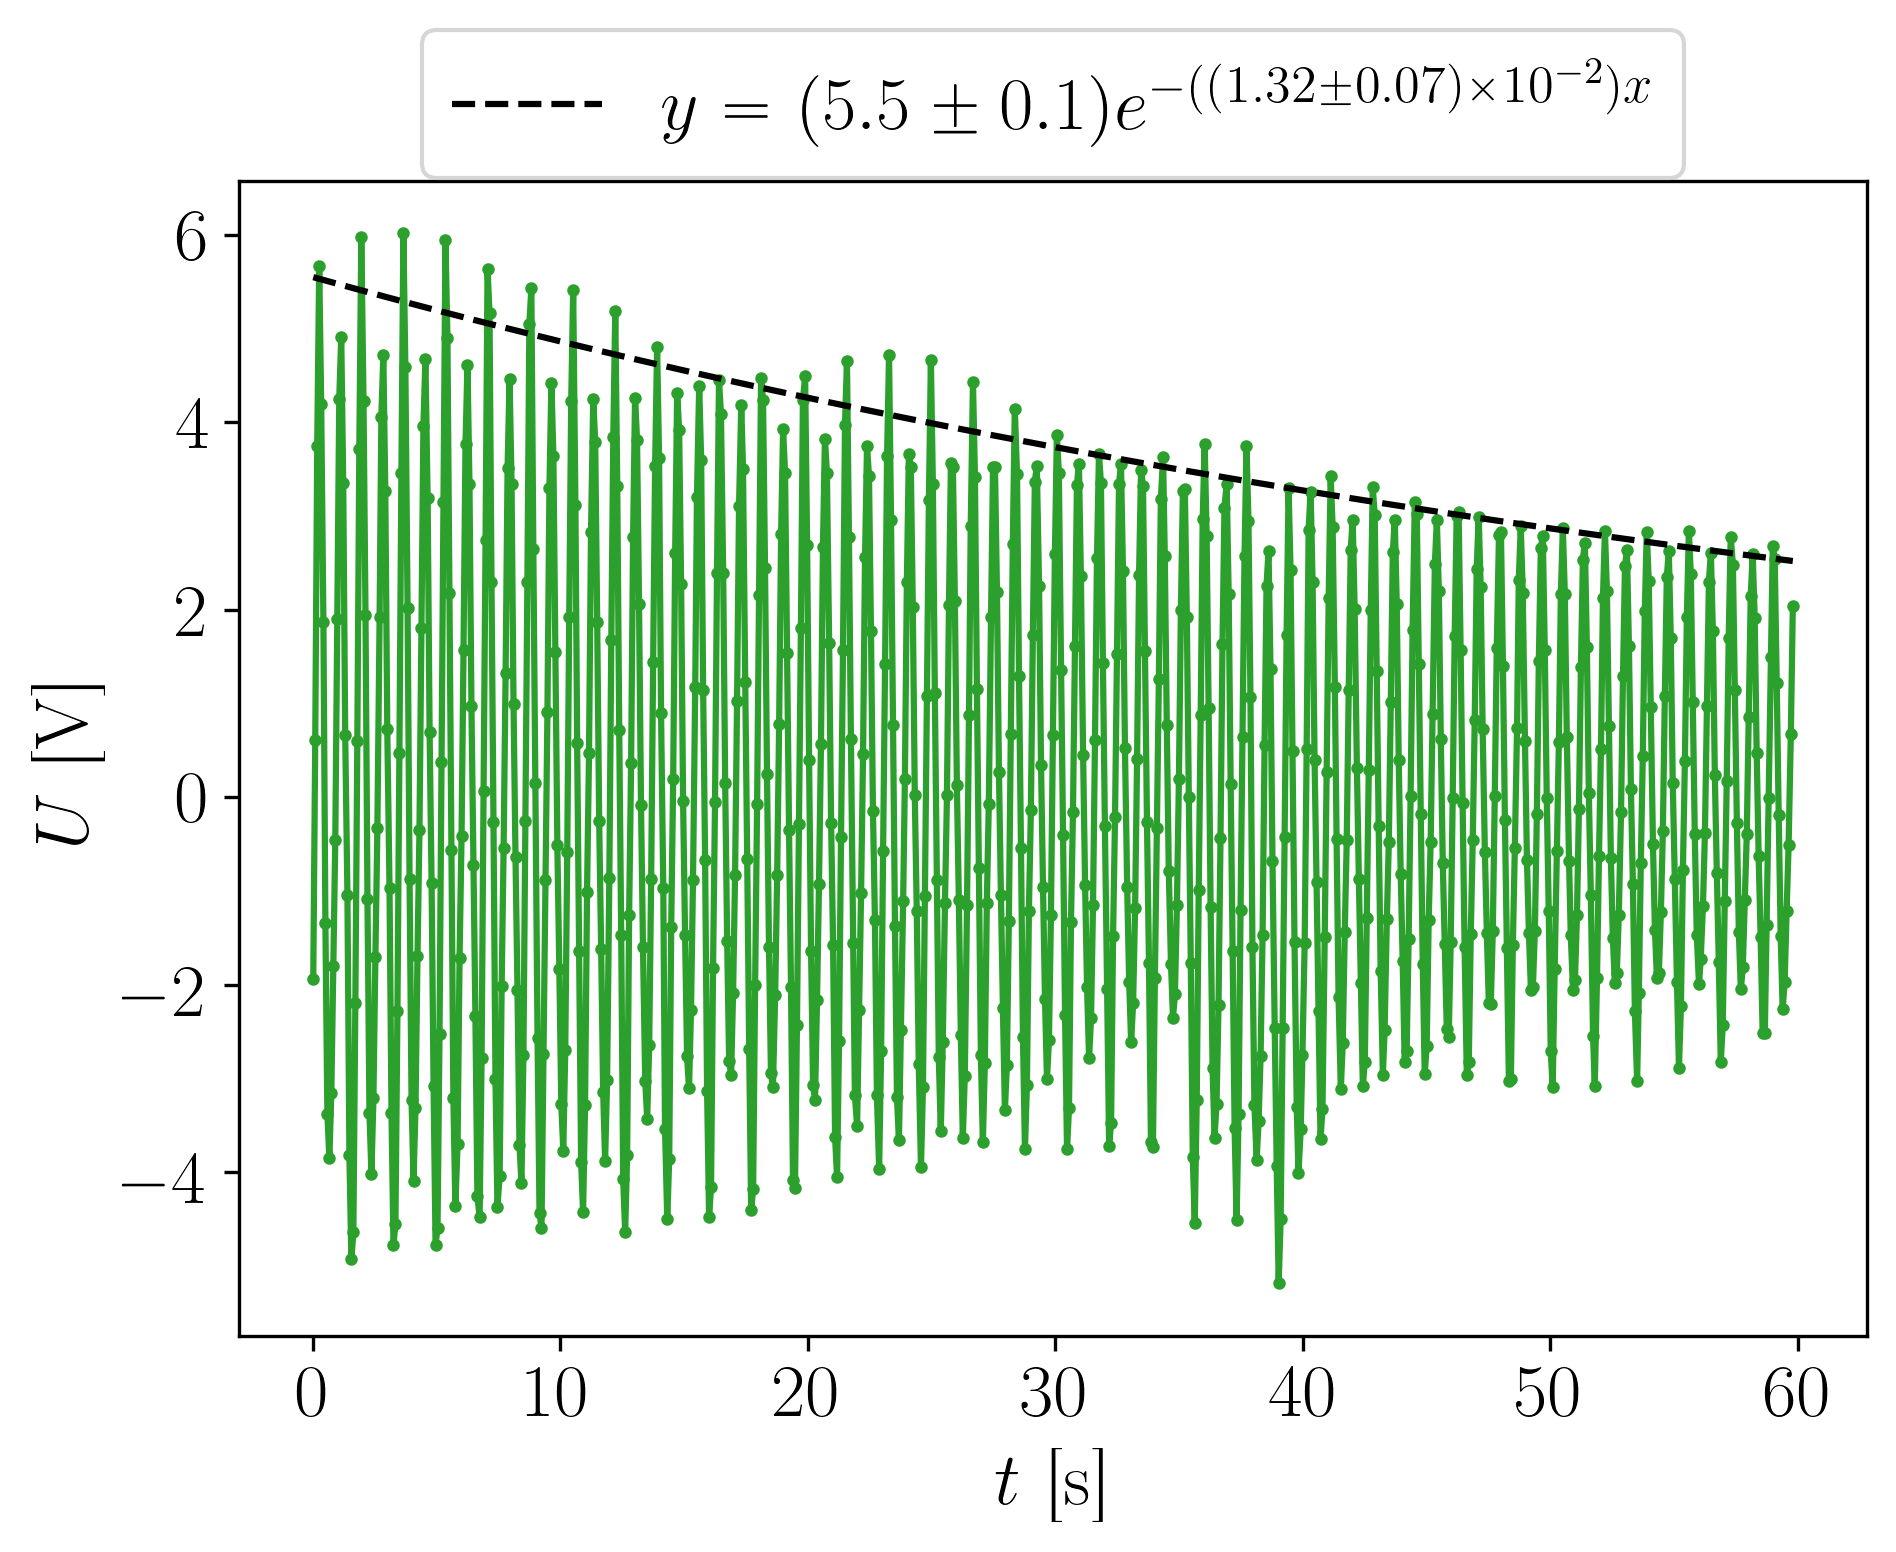

In [20]:
plot_with_fit(magnesium[0], c='tab:green')
plt.savefig('../figures/magnesium1.pdf')
plt.show()

In [22]:
def calc_period(datas):
    max_idx = local_max(datas)[0]
    delta_t = datas[0][max_idx[-1]] - datas[0][max_idx[0]]
    # for idx in max_idx:
    #     plt.axvline((datas[0][idx]).n)
    return delta_t / (len(max_idx) - 1)

In [23]:
def avg_period(dataset):
    tot = 0
    for datas in dataset:
        tot += (feur := calc_period(datas))
        print(feur)
    return tot / len(dataset)

In [24]:
laiton_period = avg_period(laiton)
print(f"Laiton: {laiton_period:.1uP} ({laiton_period:.1uL})")

acier_period = avg_period(acier)
print(f"Acier: {acier_period:.1uP} ({acier_period:.1uL})")

magnesium_period = avg_period(magnesium)
print(f"Magnesium: {magnesium_period:.1uP} ({magnesium_period:.1uL})")

2.3724+/-0.0006
2.3683+/-0.0006
2.3716+/-0.0006
Laiton: 2.3708±0.0003 (2.3708 \pm 0.0003)
1.7994+/-0.0004
1.8003+/-0.0004
1.8514+/-0.0004
Acier: 1.8170±0.0002 (1.8170 \pm 0.0002)
0.85101+/-0.00020
0.85200+/-0.00020
0.85130+/-0.00020
Magnesium: 0.8514±0.0001 (0.8514 \pm 0.0001)


## The G spot

In [25]:
I = masse_disque * (diametre_disque/2)**2 / 2

G = 128 * np.pi * I * longueur_fil_laiton * 0.01 / ((epaisseur_fil_laiton * 0.01)**4 * laiton_period**2)
print(f"Laiton: {G = :.1uP} ({G*1e-9:.1uL})")
print(abs(G * 1e-9 - 37.3) / 37.3 * 100)

G = 128 * np.pi * I * longueur_fil_acier * 0.01 / ((epaisseur_fil_acier * 0.01)**4 * acier_period**2)
print(f"acier: {G = :.1uP} ({G*1e-9:.1uL})")
print(abs(G * 1e-9 - 82.1) / 82.2 * 100)

G = 128 * np.pi * I * longueur_fil_magnesium * 0.01 / ((epaisseur_fil_magnesium * 0.01)**4 * magnesium_period**2)
print(f"magnesium: {G = :.1uP} ({G*1e-9:.1uL})")
print(abs(G * 1e-9 - 17.3) / 17.3 * 100)

Laiton: G = (3.0±0.1)×10¹⁰ (30 \pm 1)
20+/-4
acier: G = (6.4±0.3)×10¹⁰ (64 \pm 3)
22+/-4
magnesium: G = (2.16±0.08)×10¹⁰ (21.6 \pm 0.8)
25+/-5


## Décrément logarithmique